In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,langs,vtype,access,entity
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,16.0,27.0,29.0,23.0,54.0,38.0,zh.wikipedia.org,spider,all-access,2NE1
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,54.0,25.0,26.0,23.0,13.0,81.0,zh.wikipedia.org,spider,all-access,2PM
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,7.0,3.0,4.0,7.0,6.0,zh.wikipedia.org,spider,all-access,3C
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,6.0,16.0,19.0,30.0,38.0,4.0,zh.wikipedia.org,spider,all-access,4minute
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,23.0,28.0,14.0,8.0,7.0,zh.wikipedia.org,spider,all-access,52 Hz I Love You


In [114]:
sample_index=np.random.choice(traffic.index,50000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))

## prepare training and testing data

In [3]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [4]:

def normalize_X(clean_series):
    recover_dic={}
    scaled_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            scaled_series.append(np.zeros_like(clean_series[i]))
            recover_dic[i]=(0,0)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            recover_dic[i]=(std,biased_mean)
            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series,recover_dic)


def normalize_Y(clean_series,recover_dic):
    scaled_series=[]
    for i in range(len(clean_series)):
        (std,biased_mean) = recover_dic[i]
        
        if std==0:
            # ignore all zero cases
#             print(clean_series[i])
            scaled_series.append(np.zeros_like(clean_series[i]))

        else:
            

            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series)

def recover(scaled_series,recover_dic):
    recovered_series=[]
    for i in range(len(scaled_series)):
        std,biased_mean=recover_dic[i]
        new_series=scaled_series[i]*(6*float(std))+biased_mean
        recovered_series.append(new_series)
    return recovered_series

In [23]:
# encode_start=0
# encode_end=150
# decode_len=63

# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)


# train_x=clean_series
# train_y=decode_series

# encode_start=200
# encode_end=350
# decode_len=63


# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

# test_x=clean_series
# test_y=decode_series

In [115]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
train_x,train_dic = normalize_X(clean_series)
train_y = normalize_Y(decode_series,train_dic)


encode_start=200
encode_end=350
decode_len=63

PERIOD=98

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x,test_dic = normalize_X(clean_series)
test_y = normalize_Y(decode_series,test_dic)

In [25]:
# train_x[0]

In [28]:
def make_one_hots(length,last_pointer=-1):
    pointer=(last_pointer+1) % PERIOD
#     print(pointer)
    one_hots=[]
    one_hot_temp=np.zeros(PERIOD)
    for i in range(length):
        one_hot=one_hot_temp.copy()
        one_hot[pointer]=1
        one_hots.append(one_hot)
        pointer+=1
        pointer=pointer % PERIOD
    return np.array(one_hots)

In [8]:
# trainx=X_loader(train_x,batch_size)

# a,b=next(trainx)

# a.size()


In [9]:
# b[:,2:3,:],b[:,2:3,:]

In [10]:
# b[:,2:3,:]*b[:,2:3,:]

In [7]:
def X_loader(x,batchsize):
    batch=0
    x=np.array(x,dtype=np.float32)
#     x=np.log(x+1)
    one_hots=make_one_hots(len(x[0]))
    
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
        
        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [9]:

def Y_loader(y,batchsize,length_x):
    batch=0
    y=np.array(y,dtype=np.float32)
#     y=np.log(y+1)
    last_pointer=length_x % PERIOD - 1
    one_hots=make_one_hots(len(y[0]),last_pointer)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [8]:
import torch
import torch.nn as nn


In [130]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print (name, param.data)

linear.weight tensor([[-0.0206, -0.0116,  0.0320,  ..., -0.0858,  0.0821, -0.0172],
        [ 0.0041,  0.0525, -0.0148,  ..., -0.0562, -0.0768, -0.0377],
        [ 0.0671, -0.0153, -0.0581,  ...,  0.0382, -0.0799,  0.0105],
        ...,
        [ 0.0072, -0.0801, -0.0851,  ...,  0.0776,  0.0070, -0.0028],
        [ 0.0435, -0.0568,  0.0203,  ..., -0.0236,  0.0280,  0.0604],
        [-0.0198, -0.0472, -0.0448,  ..., -0.0865, -0.0835,  0.0977]], device='cuda:0')


In [29]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
#     true=torch.exp(true)-1
#     predicted=torch.exp(predicted)-1
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [116]:
from torch import optim
from numpy import random as random
epoch=190
indicator=5

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
input_size=PERIOD
hidden_size=PERIOD
output_size=1
lr=0.1
batch_size=128
encoder=EncoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(input_size,63).cuda() if use_cuda else DecoderRNN(1,hidden_size)
# teacher_forcing_ratio = 0.4
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

In [ ]:
# ps,_,score = valid_iter(test_x, test_y)
# for kk in range(12):
#     plt.plot(ps[kk][:21])
#     plt.title('epoch '+str(0))
# plt.show()
# print("Validation! Epoch: {}; Loss: {}\n".format(-1, np.mean(score)))
for i in range(epoch):
    
    trainx=X_loader(train_x,batch_size)
    trainy=Y_loader(train_y,batch_size,len(train_x[0]))
    
    running_loss_e = 0.0
    running_loss_d = 0.0
#     validation(test_x,test_y)
    for j,(X_batch,x_feature) in enumerate(trainx):
        #Parse loaded batch
        x=X_batch
        y,y_feature=next(trainy)
        
        e_loss,d_loss=train(x, x_feature, y, y_feature, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss_e += e_loss
        running_loss_d += d_loss
        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; encoding Loss: {};decoding Loss: {}\n".format(i, j, \
                                running_loss_e / indicator,running_loss_d / indicator))
            running_loss_e = 0.0
            running_loss_d = 0.0
        
    ps,_,score,_ = valid_iter(test_x, test_y)
#     for kk in range(1):
#         plt.plot(ps[kk][:21])
#         plt.title('epoch '+str(i))
#     plt.show()
    print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))

In [118]:
preds,targets,scores,es=valid_iter(test_x,test_y)

In [119]:
preds=recover(preds,test_dic)
recovered_test_x=recover(test_x,test_dic)
targets=recover(targets,test_dic)
es=recover(es,test_dic)

In [120]:
from util.evaluation import SMAPE as cpu_SMAPE
mean_scores=[]


for ID in range(40):

    pred=preds[ID]
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(cpu_SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

0.5744653964140926

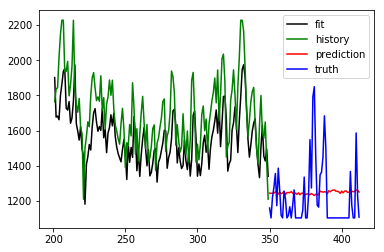

In [124]:
ID=3890
# source=sample_series[ID][encode_start:encode_end]
source=recovered_test_x[ID]
pred=preds[ID]
truth=targets[ID]
# print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start+1,encode_end),es[ID][:-1],color='black',label='fit')
plt.plot(np.arange(encode_start+1,encode_end),source[1:],color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [59]:
def valid_iter(test_x,test_y):
    testx=X_loader(test_x,batchsize=batch_size)
    testy=Y_loader(test_y,batchsize=batch_size,length_x=len(test_x[0]))

    preds=[]
    targets=[]
    e_outs=[]
    scores=[]
    for j,(X_batch,x_feature) in enumerate(testx):
        #Parse loaded batch
        print(j,end='\r')
        target,y_feature=next(testy)

    
        score,out,e_out = valid(X_batch,x_feature, target,y_feature, encoder, decoder, SMAPE)
        out=out
        scores.append(score)
        target=target.squeeze().detach().cpu().numpy()
        if j ==0:
            preds=out
            targets=target
            e_outs=e_out
        else:
            preds=np.concatenate((preds,out),axis=0)
#             print(preds.shape)
            e_outs=np.concatenate((e_outs,e_out),axis=0)
            targets=np.concatenate((targets,target),axis=0)
    return (preds,targets,scores,e_outs)

In [14]:
class SRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size=input_size
        self.forget_w = nn.Linear(input_size, hidden_size,bias=True)
        self.out_w = nn.Linear(hidden_size, hidden_size,bias=True)
    def forward(self, Input, hidden):
        #input size: is
        #batch size: bs
        #hidden size: hs
        
        #input:(bs,is)
        #hidden:(bs,hs)
        
        #(bs,hs)
        Z=torch.sigmoid(self.forget_w(Input))
        #(bs,hs)
        new_hidden=Z*Input+(1-Z)*hidden
        O=torch.sigmoid(self.out_w(Input))
        output=O*new_hidden+(1-O)*Input
        return new_hidden,output

In [77]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
#         self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
#         self.rnnc = nn.RNNCell(input_size, hidden_size, bias=True, nonlinearity='relu')
        self.rnnc = SRU(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1)
        #feature:(bs,fs)
        #hidden:(bs,1,hs)
        
        input_x=input_x.expand(input_x.size(0),feature.size(1))
        #(bs,fs)
        rnn_input=input_x*feature
        #(bs,hs)(bs,hs)
        hidden,output = self.rnnc(rnn_input, hidden)
        #(bs,hs)
#         hidden = output
        #(bs,1)
        output = torch.sum(feature*output,1,keepdim=True)
        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1),(bs,hs)
        return output, hidden

    def initHidden(self,b_size):
        
#         nn.init.xavier_normal_(self.out)
        paras= torch.sigmoid(nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size))).cuda() if use_cuda else \
                torch.sigmoid(nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size)))
        return paras

class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DecoderRNN, self).__init__()

        self.linear=nn.Linear(input_size,output_size,bias=False)
    def forward(self, input_x):
        #batchsize: bs
        #input size:is
        #output size: os
        
        #input_x:(bs,is)
        #(bs,os)
        output=self.linear(input_x)
        return output

def train(input_variable, input_feature, target_variable, target_feature, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden(input_variable.size(0))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
#     encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
#     encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss_encoding = 0

    for ei in range(input_length-1):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei,:],input_feature[:,ei,:], encoder_hidden)
        loss_encoding += criterion(encoder_output.squeeze(),input_variable[:,ei+1,:].squeeze())
#         encoder_outputs[ei] = encoder_output[0,0,:]
#     print('-'*90)
#     print('pred')
#     print(encoder_output.size())
#     print(encoder_output)
#     print('target')
#     print(input_variable[:,ei+1:(ei+2),:].size())
#     print(input_variable[:,ei+1:(ei+2),:])
#     print(criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze()))
#     print('-'*90)
    #get the first prediction
    encoder_output, encoder_hidden = encoder(input_variable[:,ei+1,:],input_feature[:,ei+1,:],\
                                             encoder_hidden)
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    
    decoder_output = decoder(encoder_hidden)

    loss_decoding = criterion(decoder_output.squeeze(), target_variable.squeeze())
#     loss=loss_encoding+loss_decoding
    loss=loss_decoding
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ((loss_encoding.item() / (input_length-1)),(loss_decoding.item()))

In [136]:
def valid(input_variable, input_feature, target_variable, target_feature, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    encoder_hidden = encoder.initHidden(input_variable.size(0))
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
#     print(target_length)
    
    loss = 0
    encoder_outputs=[]
    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei,:],input_feature[:,ei,:], encoder_hidden)
        encoder_outputs.append(encoder_output.squeeze().detach().cpu().numpy())
#     print(encoder_hidden[0,20:25])
#     decoder_output = decoder(encoder_hidden)
    decoder_output = encoder_hidden[:,-63:]
    
    outputs=decoder_output.detach().cpu().numpy()
    loss_decoding = criterion(decoder_output.squeeze(), target_variable.squeeze())
#     loss=loss_encoding+loss_decoding
    loss=loss_decoding


    return (loss.item(),np.array(outputs),np.array(encoder_outputs).T)

In [137]:
preds,targets,scores,es=valid_iter(test_x,test_y)

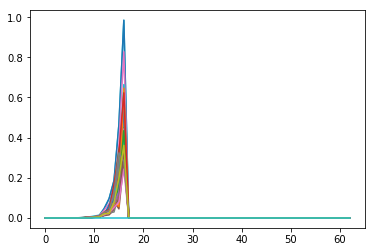

In [140]:
for i in range(50):
    plt.plot(preds[i])
#     plt.plot(targets[i][:21])
#     plt.plot(preds[213])

In [141]:
150-98

52

In [142]:
98-63

35